## Random Forest for COVID Case Study
by [Sonjoy Das, PhD](https://www.linkedin.com/in/sonjoydas/)

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` (re: [sklearn.ensemble.BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)) to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The `BaggingClassifier` (commented out below) is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model (or uncomment the `BaggingClassifier` and comment out the `RandomForestClassifier`), using the Iris dataset to classify the data into the appropriate species.

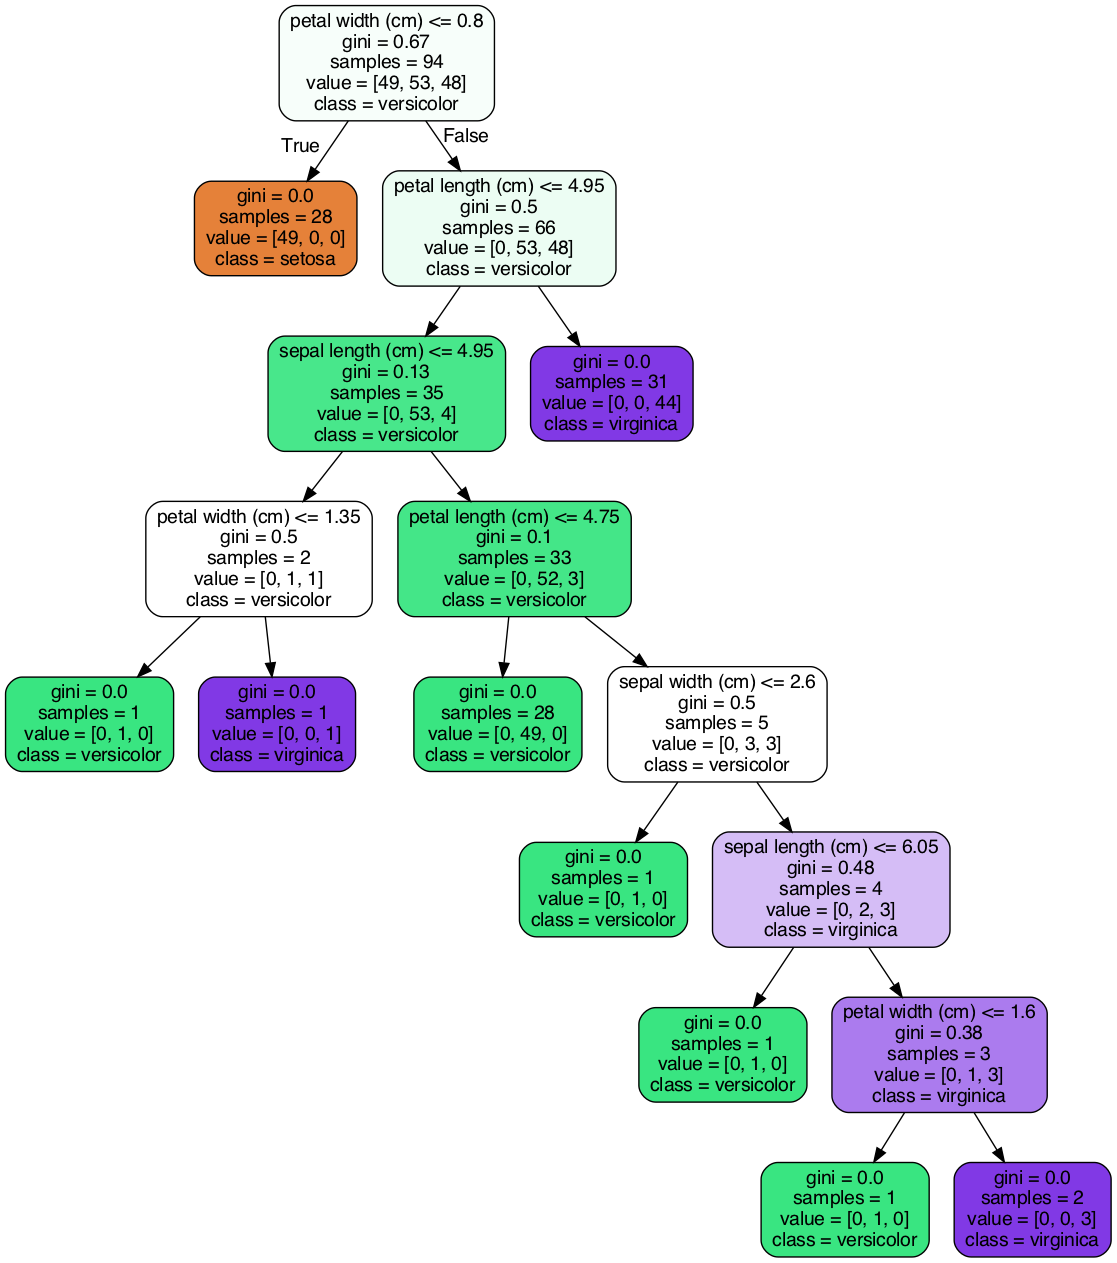

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
model = RandomForestClassifier(n_estimators=10, random_state = 0)
# model = BaggingClassifier(n_estimators=10, random_state = 0)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=100'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. There is a detailed guideline of preventive actions against COVID-19 available now (Ref: [CDC guidelines](https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/prevention.html)).  An outbreak of COVID-19 started in December 2019 and is still continuing throughout the world. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study is designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19. The goal of this work is to build a Random Forest Classifier to predict the 'state' of the patient.

## Imports

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import itertools

## Load and Explore Data

In [3]:
file ='SouthKoreacoronavirusdataset/PatientInfo.csv'
# df = pd.read_csv(url)
df = pd.read_csv(file, parse_dates = ['symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date'])
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaT,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaT,2020-01-30,2020-03-02,NaT,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaT,2020-01-30,2020-02-19,NaT,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaT,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaT,2020-01-31,2020-02-24,NaT,released


In [4]:
df.shape

(2218, 18)

In [5]:
# #Counts of null values 
# na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
# na_df.columns = ['VarName', 'NullCount']
# na_df[(na_df['NullCount']>0)]

#Counts of null values 
def count_null_values(data):
    na_df=pd.DataFrame(data.isnull().sum().sort_values(ascending=False)).reset_index()
    na_df.columns = ['VarName', 'NullCount']
    na_df = na_df[(na_df['NullCount']>0)]
    return na_df

count_null_values(df)

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts(dropna = False)

isolated    1791
released     307
NaN           88
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
df['birth_year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: birth_year
Non-Null Count  Dtype  
--------------  -----  
1764 non-null   float64
dtypes: float64(1)
memory usage: 17.5 KB


In [8]:
df['confirmed_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: confirmed_date
Non-Null Count  Dtype         
--------------  -----         
2077 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.5 KB


In [9]:
# df['n_age'] = df['birth_year'].apply(lambda x: date.today().year - x)
df['n_age'] = (df['confirmed_date'].dt.year.astype('float64')) - df['birth_year']
df.n_age

0       56.0
1       33.0
2       56.0
3       29.0
4       28.0
        ... 
2213    30.0
2214    22.0
2215    22.0
2216    48.0
2217    46.0
Name: n_age, Length: 2218, dtype: float64

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [10]:
count_null_values(df)

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,n_age,455


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          2218 non-null   int64         
 1   global_num          1314 non-null   float64       
 2   sex                 2073 non-null   object        
 3   birth_year          1764 non-null   float64       
 4   age                 1957 non-null   object        
 5   country             2218 non-null   object        
 6   province            2218 non-null   object        
 7   city                2153 non-null   object        
 8   disease             19 non-null     object        
 9   infection_case      1163 non-null   object        
 10  infection_order     42 non-null     float64       
 11  infected_by         469 non-null    float64       
 12  contact_number      411 non-null    float64       
 13  symptom_onset_date  193 non-null    datetime64[n

<u>`disease` column</u>

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [12]:
df.disease = df.disease.map({True:1, np.nan:0})
df.disease.value_counts()

0    2199
1      19
Name: disease, dtype: int64

In [13]:
df.disease.isnull().sum()

0

<u>`birth_year` column</u>

Since we already have `age` and `n_age` column, let's drop the `birth_year` column.

In [14]:
df.drop(['birth_year'], axis=1, inplace=True)

<u>`global_number`, `infection_order`, `infected_by` and `contact_number` columns</u>

 **<font color='teal'>Fill null values in the following columns with their mean: 'global_number', 'infection_order', 'infected_by' and 'contact_number'</font>**

In [15]:
features = ['global_num', 'infection_order','infected_by','contact_number']

df[features] = df[features].fillna(df[features].mean())

In [16]:
print(f"global_num\n\n{df.global_num.value_counts()}\n\n")
print(f"infection_order\n\n{df.infection_order.value_counts()}\n\n")
print(f"infected_by\n\n{df.infected_by.value_counts()}\n\n")
print(f"contact_number\n\n{df.contact_number.value_counts()}\n\n")

global_num

4664.816591    904
1753.000000      2
8476.000000      2
2769.000000      2
7103.000000      2
              ... 
392.000000       1
649.000000       1
565.000000       1
574.000000       1
5534.000000      1
Name: global_num, Length: 1304, dtype: int64


infection_order

2.285714    2176
2.000000      19
1.000000      11
3.000000       6
5.000000       3
4.000000       2
6.000000       1
Name: infection_order, dtype: int64


infected_by

2.600789e+09    1749
2.000000e+09      44
4.100000e+09      27
4.100000e+09      21
2.000000e+09      17
                ... 
2.000000e+09       1
2.000000e+09       1
2.000000e+09       1
2.002000e+09       1
6.113000e+09       1
Name: infected_by, Length: 207, dtype: int64


contact_number

24.128954     1807
0.000000        47
2.000000        44
3.000000        42
1.000000        34
              ... 
450.000000       1
65.000000        1
156.000000       1
39.000000        1
84.000000        1
Name: contact_number, Length: 73, dtype: i

**<font color='teal'>Remove date columns from the data.</font>**

In [17]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

**<font color='teal'> Check for any remaining null values.</font>**

In [18]:
count_null_values(df)

,VarName,NullCount
0,infection_case,1055
1,n_age,455
2,age,261
3,sex,145
4,state,88
5,city,65


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

<u>`age` and `n_age` columns</u>

In [19]:
df.age.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: age
Non-Null Count  Dtype 
--------------  ----- 
1957 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [20]:
age_keys = list(df.age.value_counts().index)
age_keys

['20s', '50s', '40s', '30s', '60s', '70s', '80s', '10s', '0s', '90s', '100s']

Remove the 's' from the end and convert the datatype from `object` to `int` for the `age` column.

In [21]:
age_values = [x[:-1] for x in age_keys]
age_values = [int(i) for i in age_values]
age_values

[20, 50, 40, 30, 60, 70, 80, 10, 0, 90, 100]

In [22]:
# using zip() to create a dictionary to use in `.replace` function
age_dict = dict(zip(age_keys, age_values))
age_dict

{'20s': 20,
 '50s': 50,
 '40s': 40,
 '30s': 30,
 '60s': 60,
 '70s': 70,
 '80s': 80,
 '10s': 10,
 '0s': 0,
 '90s': 90,
 '100s': 100}

In [23]:
df["age"].replace(age_dict, inplace=True)
df["age"] = df["age"].astype('Int64')
df.age.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: age
Non-Null Count  Dtype
--------------  -----
1957 non-null   Int64
dtypes: Int64(1)
memory usage: 19.6 KB


In [24]:
df.n_age.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: n_age
Non-Null Count  Dtype  
--------------  -----  
1763 non-null   float64
dtypes: float64(1)
memory usage: 17.5 KB


**<u>Note</u>**: We see that the `age` column has 1957 entries while the newly created `n_age` column has 1763 entries. We need to get some of the missing values of `n_age` from `age` column.

Replace the missing values of `n_age` by the available values of the `age` column.

In [25]:
index_missing_nage = df[['age', 'n_age']].loc[df.n_age.isnull()].index
df[['age', 'n_age']].iloc[index_missing_nage]

,age,n_age
446,40,NaN
447,20,NaN
448,30,NaN
449,30,NaN
450,30,NaN
...,...,...
2128,0,NaN
2136,70,NaN
2159,<NA>,NaN
2160,<NA>,NaN


In [26]:
df.n_age.fillna(df.age, inplace=True)
df[['age', 'n_age']].iloc[index_missing_nage]

,age,n_age
446,40,40.0
447,20,20.0
448,30,30.0
449,30,30.0
450,30,30.0
...,...,...
2128,0,0.0
2136,70,70.0
2159,<NA>,<NA>
2160,<NA>,<NA>


In [27]:
df[['age', 'n_age']].isnull().sum()

age      261
n_age    151
dtype: int64

We can now drop the `age` column.

In [28]:
df.drop(['age'], axis=1, inplace=True)

Fill null values of `n_age` column by its mean.

In [29]:
df['n_age'] = df['n_age'].fillna(df['n_age'].mean())

In [30]:
df.n_age.isnull().sum()

0

<u>`sex` column</u>

In [31]:
df.sex.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: sex
Non-Null Count  Dtype 
--------------  ----- 
2073 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [32]:
df.sex.value_counts(dropna = False)

female    1171
male       902
NaN        145
Name: sex, dtype: int64

In [33]:
df.sex.mode()

0    female
Name: sex, dtype: object

We will use `mode` value to impute the `sex` column.

In [34]:
df.sex = df.sex.fillna('female')

In [35]:
df.sex.isnull().sum()

0

<u>`city` column</u>

In [36]:
df.city.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: city
Non-Null Count  Dtype 
--------------  ----- 
2153 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


Note that there is no missing values for `province`.

In [37]:
df.province.isnull().sum()

0

Replace the missing values of `city` by the corresponding values of the `province` column.

In [38]:
df.city.fillna(df.province, inplace=True)

In [39]:
df.city.isnull().sum()

0

<u>`infection_case` column</u>

In [40]:
df.infection_case.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: infection_case
Non-Null Count  Dtype 
--------------  ----- 
1163 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [41]:
df.infection_case.value_counts(dropna = False)

NaN                                 1055
contact with patient                 530
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: infection_case, dtype: int64

In [42]:
df.infection_case.mode()

0    contact with patient
Name: infection_case, dtype: object

We will use `mode` value to impute the `infection_case` column.

In [43]:
df.infection_case = df.infection_case.fillna('contact with patient')

In [44]:
df.infection_case.isnull().sum()

0

In [45]:
df.infection_case.value_counts(dropna = False)

contact with patient                1585
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: infection_case, dtype: int64

<u>`state` column</u>

Replace null values in the `state` column with `missing`.

In [46]:
df.state = df.state.fillna('missing')

**<font color='teal'> Check for any remaining null values.</font>**

In [47]:
count_null_values(df)

,VarName,NullCount


**All missing values are now replaced.**

In [48]:
df.head()

,patient_id,global_num,sex,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,1000000001,2.0,male,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,released,56.0
1,1000000002,5.0,male,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,released,33.0
2,1000000003,6.0,male,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,56.0
3,1000000004,7.0,male,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,released,29.0
4,1000000005,9.0,female,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,28.0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   int64  
 1   global_num       2218 non-null   float64
 2   sex              2218 non-null   object 
 3   country          2218 non-null   object 
 4   province         2218 non-null   object 
 5   city             2218 non-null   object 
 6   disease          2218 non-null   int64  
 7   infection_case   2218 non-null   object 
 8   infection_order  2218 non-null   float64
 9   infected_by      2218 non-null   float64
 10  contact_number   2218 non-null   float64
 11  state            2218 non-null   object 
 12  n_age            2218 non-null   Float64
dtypes: Float64(1), float64(4), int64(2), object(6)
memory usage: 227.6+ KB


Review the count of unique values by column.

In [50]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
country               4
province             17
city                139
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 4
n_age                97
dtype: int64


Review the percent of unique values by column.

In [51]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
country            0.001803
province           0.007665
city               0.062669
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043733
dtype: float64


Review the range of values per column.

In [52]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.420416e+01,1.877212e+01,0.000000e+00,2.800000e+01,4.420416e+01,5.700000e+01,1.040000e+02


In [53]:
df.describe(include=[object]).T

,count,unique,top,freq
sex,2218,2,female,1316
country,2218,4,Korea,2206
province,2218,17,Gyeongsangbuk-do,1054
city,2218,139,Gyeongsan-si,535
infection_case,2218,16,contact with patient,1585
state,2218,4,isolated,1791


### Check for duplicated rows

In [54]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [55]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
print(f"dfo.shape: {dfo.shape}")

#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

dfo.shape: (2218, 6)


,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,139
4,infection_case,16
5,state,4


**<font color='teal'> Plot the correlation heat map for the features.</font>**

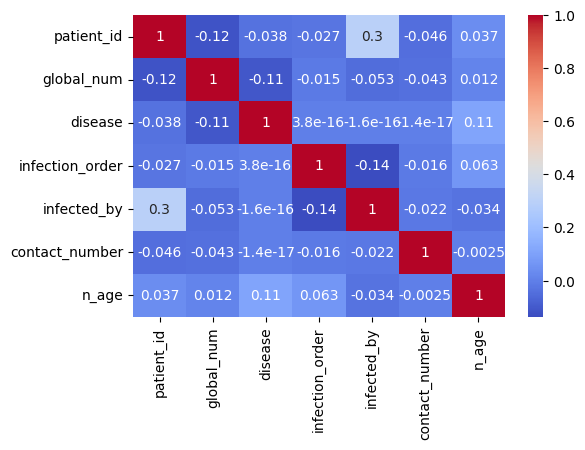

In [56]:
# Make a heatmap of the data
plt.figure(dpi = 100)

ax = sns.heatmap(df.corr(), cmap="coolwarm", annot=True, annot_kws={"fontsize": 10})

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10, rotation=90);
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10);

ax.collections[0].colorbar.ax.tick_params(labelsize=10)

We see that the **numerical features are only weakly correlated** to each other. So, we need to consider all these features as input variables for our random forest classifier.

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [57]:
df1 = df.select_dtypes(include=['int','float'])
df1_list = list(df1.columns.values)
df1_list

['patient_id',
 'global_num',
 'disease',
 'infection_order',
 'infected_by',
 'contact_number',
 'n_age']

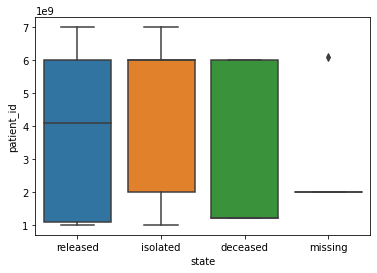

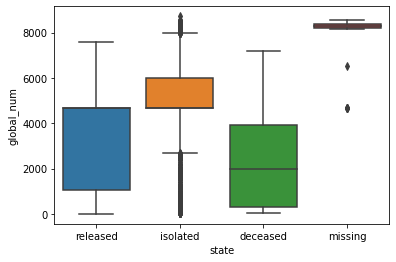

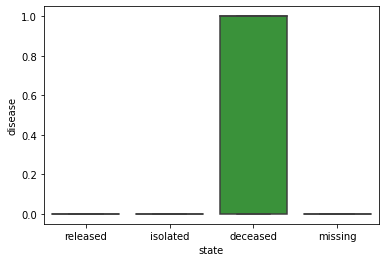

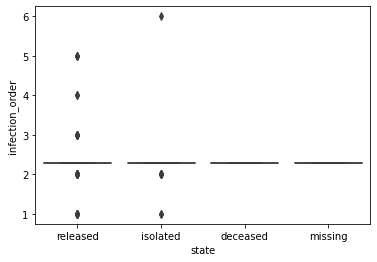

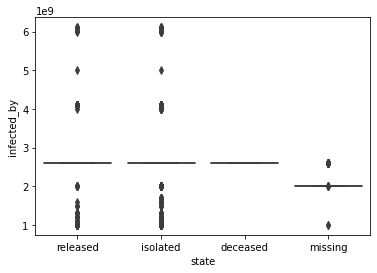

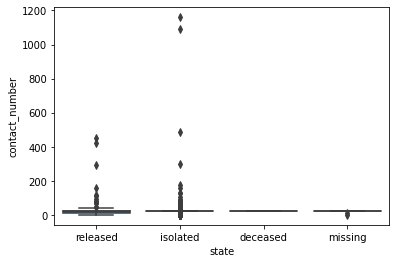

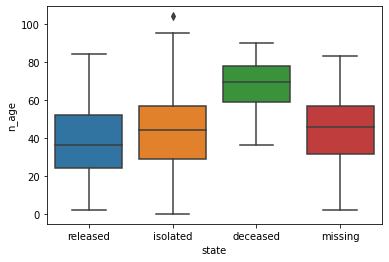

In [58]:
for feature in df1_list:
    plt.figure()
    sns.boxplot(x='state', y=feature, data=df);

Let's count the number of outliers of each numerical columns. See this [stackoverflow response](https://stackoverflow.com/questions/39068214/how-to-count-outliers-for-all-columns-in-python).

In [59]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

In [60]:
print(f"\nNumber of outliers:")
((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR))).sum()


Number of outliers:


patient_id           0
global_num         331
disease             19
infection_order     42
infected_by        469
contact_number     411
n_age                1
dtype: int64

**<font color='teal'> Create dummy features for object type features. </font>**

**Note**: A random forest classifier is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting (re: [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#:~:text=A%20random%20forest%20is%20a%20meta%20estimator%20that%20fits%20a%20number%20of%20decision%20tree%20classifiers)). 

Decision tree classifier can handle both numerical and categorical data. However, the `scikit-learn` implementation does not support categorical variables for now (re:[Decision Trees](https://scikit-learn.org/stable/modules/tree.html#:~:text=data.%20However%2C%20the-,scikit%2Dlearn%20implementation%20does%20not%20support%20categorical%20variables%20for%20now,-.%20Other%20techniques%20are)). Therefore, we will convert our categorical variables into dummy/indicator variables (re: [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)) using one-hot-encoding.

In [61]:
X = pd.get_dummies(df.drop('state', axis=1))
print(f"X.shape: {X.shape}")
X.head()

X.shape: (2218, 185)


,patient_id,global_num,disease,infection_order,infected_by,contact_number,n_age,sex_female,sex_male,country_China,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1000000001,2.0,0,1.0,2.600789e+09,75.0,56.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1000000002,5.0,0,1.0,2.600789e+09,31.0,33.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1000000003,6.0,0,2.0,2.002000e+09,17.0,56.0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1000000004,7.0,0,1.0,2.600789e+09,9.0,29.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1000000005,9.0,0,2.0,1.000000e+09,2.0,28.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [62]:
y = df['state']
print(f"\ny.shape: {y.shape}\n")
y.value_counts()


y.shape: (2218,)



isolated    1791
released     307
missing       88
deceased      32
Name: state, dtype: int64

### Split the data into test and train subsamples

Make sure you also pass `stratify = y` to split the data in a stratified fashion.

In [63]:
# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify = y)

### Scaling of Data

The random forest classification algorithm is based on multiple decision tree classifiers, and the decision tree classifier requires little data preparation (re: [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#:~:text=Requires%20little%20data%20preparation)). The decision tree classifier uses partitioning, i.e., a set of if-then-else decision rules; see [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#:~:text=a%20set%20of%20if%2Dthen%2Delse%20decision%20rules). Even if you apply feature scaling, the result would still be the same. Hence, we will **not apply any scaling on our data**.

**Side Note**: Note that the feature scaling slightly affects the results of the random forest regressors (see this [article](https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf)). But, the results are practically same.

In [64]:
#scale data
# from sklearn import preprocessing
# import numpy as np
# # build scaler based on training data and apply it to test data to then also scale the test data
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled=scaler.transform(X_train)
# X_test_scaled=scaler.transform(X_test)

### Fit Random Forest Classifier

In [65]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.865
Random Forest: f1-score=0.854


The fit model shows an overall accuracy of 86.5% with a f1-score of 0.854. This is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [66]:
# class_names = ['isolated','released','missing','deceased'] # name  of classes
class_names = list(y_train.value_counts(dropna = False).index)
class_names

['isolated', 'released', 'missing', 'deceased']

In [67]:
y_train.value_counts(dropna = False)

isolated    1432
released     246
missing       70
deceased      26
Name: state, dtype: int64

Confusion matrix, without normalization
[[  6   0   0   0]
 [  0 339   2  18]
 [  0   2  16   0]
 [  0  38   0  23]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.94 0.01 0.05]
 [0.   0.11 0.89 0.  ]
 [0.   0.62 0.   0.38]]


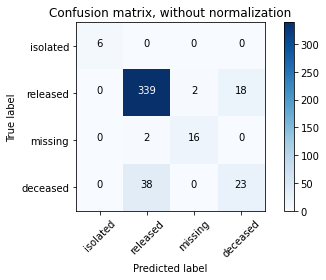

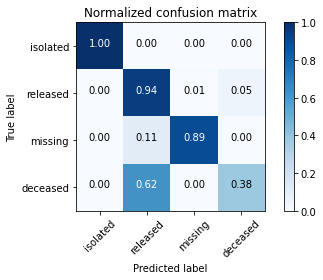

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Even though our model has a fairly good overall accuracy of 86.5% and a f1-score of 0.854, it could not classify the `deceased` state well. It has a very low recall score for the `deceased` state (38% -- see below), which is possibly of significant concern.

In [69]:
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    isolated       1.00      1.00      1.00         6
    released       0.89      0.94      0.92       359
     missing       0.89      0.89      0.89        18
    deceased       0.56      0.38      0.45        61

    accuracy                           0.86       444
   macro avg       0.84      0.80      0.81       444
weighted avg       0.85      0.86      0.85       444



### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

In [70]:
feature_importance = clf.feature_importances_
len(feature_importance)

185

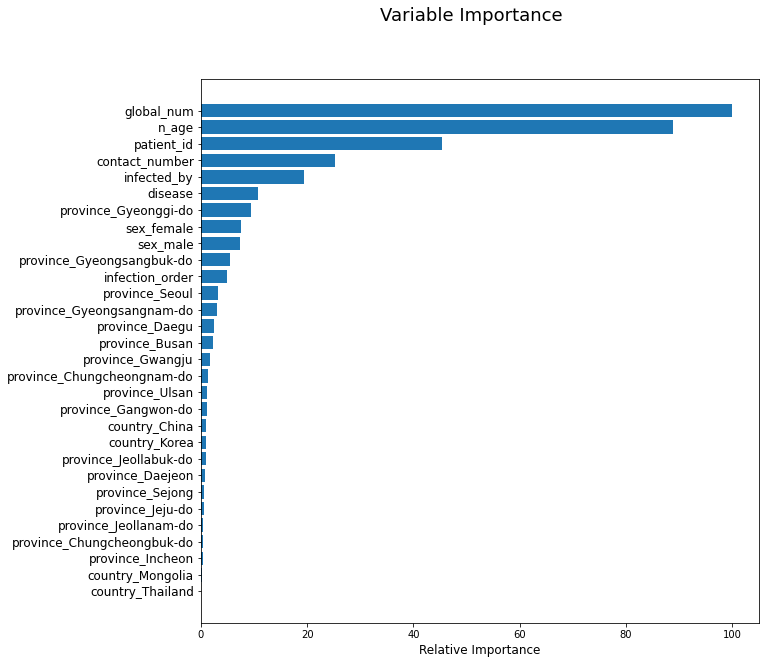

In [71]:
n_feature_importance = 30 # Plot for top 30 important features

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:n_feature_importance]
sorted_idx = np.argsort(feature_importance)[:n_feature_importance]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx], fontsize = 12)
plt.xlabel('Relative Importance', fontsize = 12)
plt.suptitle('Variable Importance', fontsize = 18)
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.